In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import warnings
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
ds=pd.read_csv('/content/sample_data/insurance.csv')
ds.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


Split the dataset to train and test and predict the value for new customers

In [11]:
ds.duplicated().sum()

1

In [12]:
ds.drop_duplicates()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
995,39,female,23.275,3,no,northeast,7986.47525
996,39,female,34.100,3,no,southwest,7418.52200
997,63,female,36.850,0,no,southeast,13887.96850
998,33,female,36.290,3,no,northeast,6551.75010


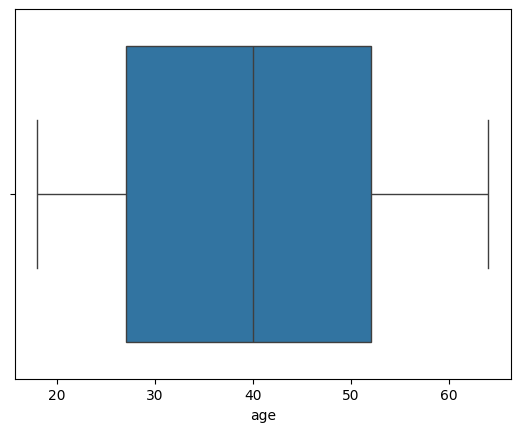

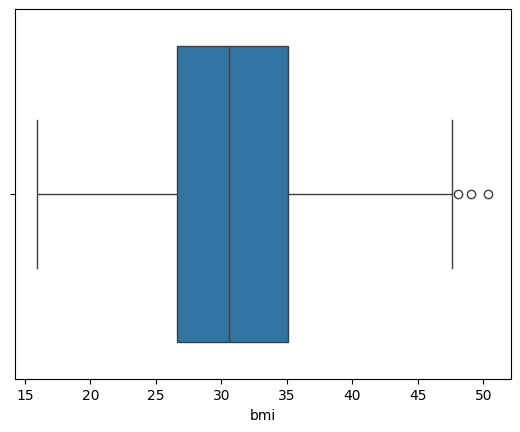

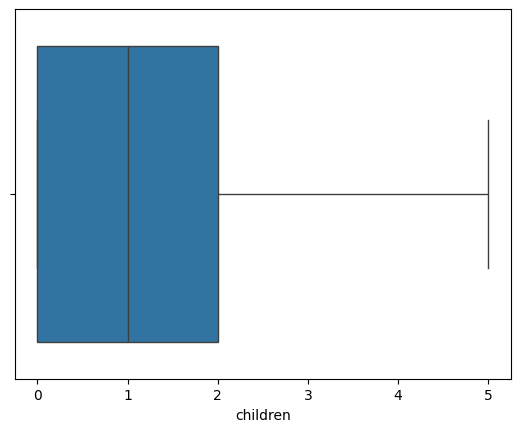

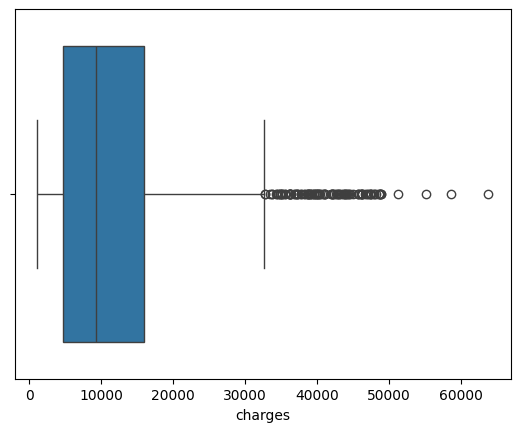

In [15]:
warnings.filterwarnings('ignore')
ds.describe(include='object')
for i in ds.select_dtypes(include='number').columns:
  sb.boxplot(data=ds,x=i)
  plt.show()

In [47]:
columns=ds.select_dtypes(include=['object']).columns
label_encoders={}
for column in columns:
    le=LabelEncoder()
    ds[column]=le.fit_transform(ds[column])
    label_encoders[column]=le
ds.head()


,age,sex,bmi,children,smoker,region,charges
0,19.0,0.0,27.900,0.0,0.0,3.0,16884.92400
1,18.0,1.0,33.770,1.0,0.0,2.0,1725.55230
2,28.0,1.0,33.000,3.0,0.0,2.0,4449.46200
3,33.0,1.0,22.705,0.0,0.0,1.0,21984.47061
4,32.0,1.0,28.880,0.0,0.0,1.0,3866.85520


<Axes: >

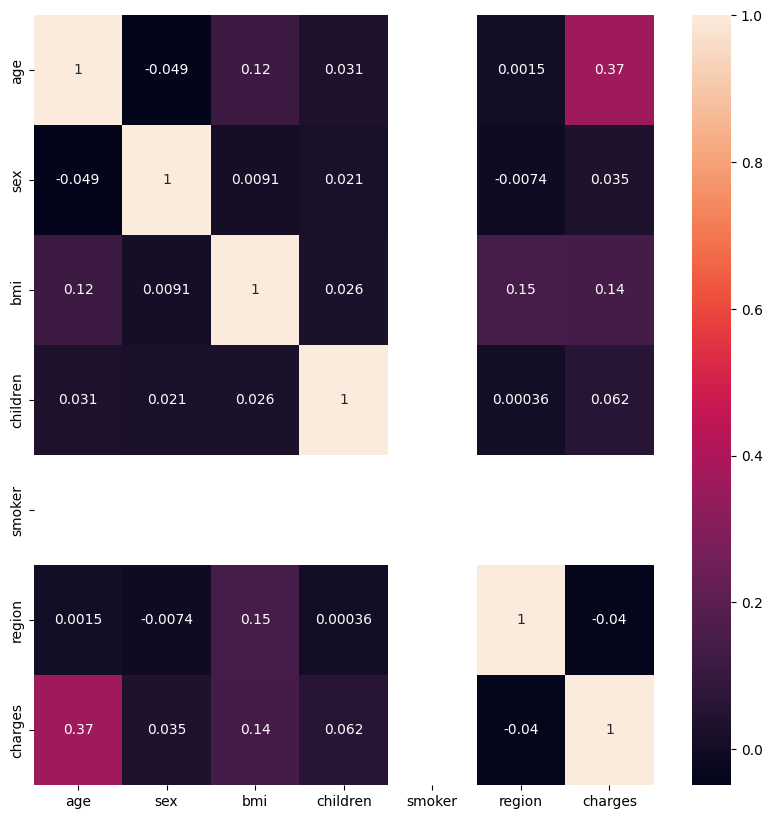

In [49]:
corr1=ds.select_dtypes(include='number').corr()
plt.figure(figsize=(10,10))
sb.heatmap(corr1,annot=True)

Remove outliers

In [35]:
def wisker(col):
  q1,q3=np.percentile(col,[25,75])
  iqr=q3-q1
  lower=q1-1.5*iqr
  upper=q3+1.5*iqr
  return lower,upper
for i in ['age','sex','bmi','children','smoker','region','charges']:
       lower,upper=wisker(ds[i])
       ds[i]=np.where(ds[i]<lower,lower,ds[i])
       ds[i]=np.where(ds[i]>upper,upper,ds[i])

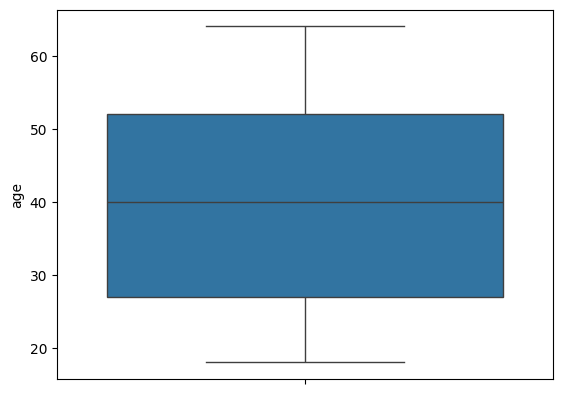

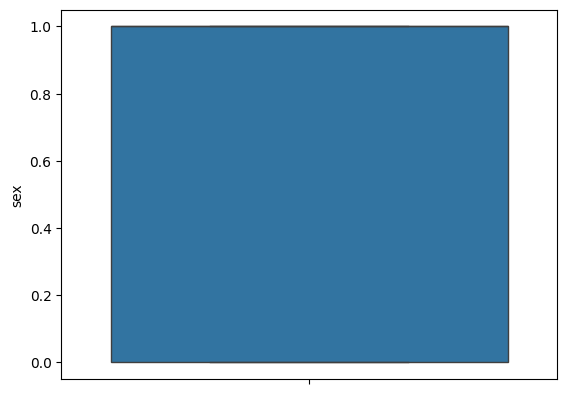

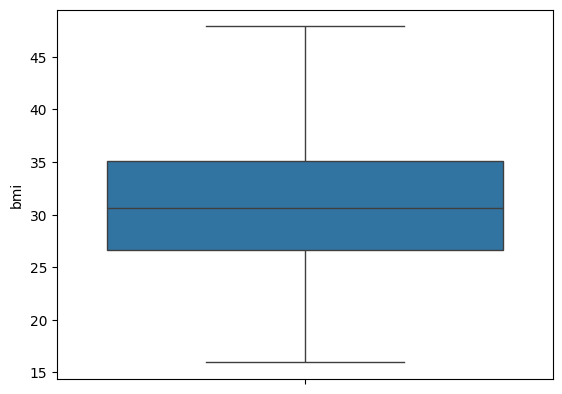

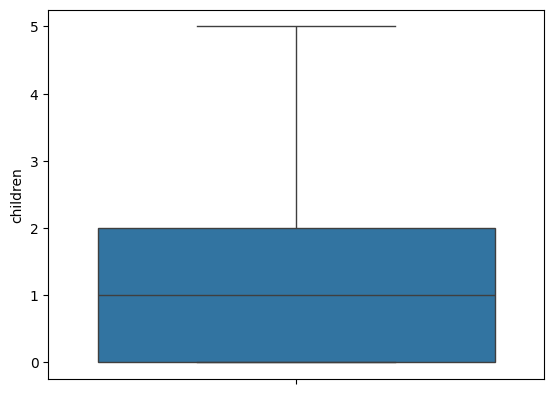

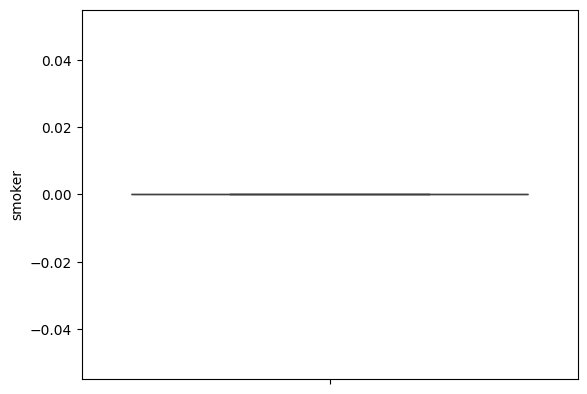

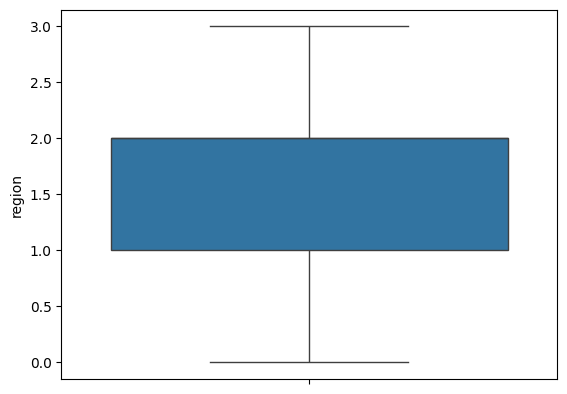

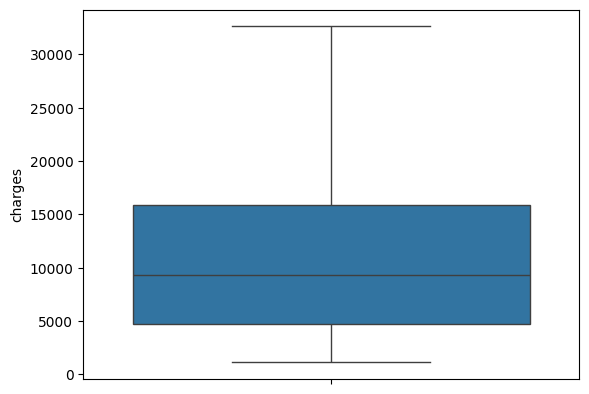

In [36]:
for i in ['age','sex','bmi','children','smoker','region','charges']:
       sb.boxplot(ds[i])
       plt.show()

In [37]:
X=ds.drop('charges',axis=1)
y=ds['charges']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.15,random_state=42)
scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

Hyperparameter tuning


In [43]:
from sklearn.ensemble import GradientBoostingRegressor
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)
print(model.score(X_test,y_test))
y_pred = model.predict(X_test)


0.8806830430924685
0.8939463680314649


In [51]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
rf_param_grid={
    'n_estimators':[100,200,300],
    'max_depth':[None,10,20,30],
    'min_samples_split':[2,5,10],
    'min_samples_leaf':[1,2,4],
    'bootstrap':[True,False]
}
gbr_param_grid={
    'n_estimators':[100,200,300],
    'learning_rate':[0.01,0.1,0.05],
    'max_depth':[3,4,5],
    'min_samples_split':[2,5,10],
    'min_samples_leaf':[1,2,4],
    'subsample':[0.8,1.0]
}
rf_grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                              param_grid=rf_param_grid,
                              cv=3,
                              n_jobs=-1,
                              verbose=2,
                              scoring='neg_mean_squared_error')
rf_grid_search.fit(X_train, y_train)
gbr_grid_search = GridSearchCV(estimator=GradientBoostingRegressor(random_state=42),
                               param_grid=gbr_param_grid,
                               cv=3,
                               n_jobs=-1,
                               verbose=2,
                               scoring='neg_mean_squared_error')

gbr_grid_search.fit(X_train, y_train)
gbr_grid_search.score(X_train, y_train)


Fitting 3 folds for each of 216 candidates, totalling 648 fits
Fitting 3 folds for each of 486 candidates, totalling 1458 fits


-15637602.152376225

In [54]:

rf_best=rf_grid_search.best_estimator_
rf_best_score = rf_grid_search.best_score_
gbr_best = gbr_grid_search.best_estimator_
gbr_best_score = gbr_grid_search.best_score_
print("Best RF Score (MSE):",-rf_best_score)
print("Best GBR Score (MSE):", -gbr_best_score)
rf_pred = rf_best.predict(X_test)
rf_mse = mean_squared_error(y_test, rf_pred)
rf_rmse = np.sqrt(rf_mse)
gbr_pred = gbr_best.predict(X_test)
gbr_mse = mean_squared_error(y_test, gbr_pred)
gbr_rmse = np.sqrt(gbr_mse)

print("Random Forest Test RMSE:", rf_rmse)
print("Gradient Boosting Test RMSE:", gbr_rmse)


Best RF Score (MSE): 21178155.751072604
Best GBR Score (MSE): 20425480.893129453
Random Forest Test RMSE: 4581.9829962825
Gradient Boosting Test RMSE: 4463.627608735696


In [55]:
from sklearn.metrics import r2_score
rf_r2 = r2_score(y_test,rf_pred)
gbr_r2 = r2_score(y_test,gbr_pred)
print("Random Forest Test R-squared:", rf_r2)
print("Gradient Boosting Test R-squared:", gbr_r2)

Random Forest Test R-squared: 0.8925011315943625
Gradient Boosting Test R-squared: 0.8979829275538163


In [56]:
from sklearn.metrics import mean_absolute_error, median_absolute_error
def evaluate_model(y_true,y_pred,model_name):
    mse=mean_squared_error(y_true,y_pred)
    rmse=np.sqrt(mse)
    mae=mean_absolute_error(y_true,y_pred)
    medae=median_absolute_error(y_true,y_pred)
    r2=r2_score(y_true,y_pred)
    print(f"{model_name} Evaluation:")
    print(f"MSE:{mse:.4f}")
    print(f"RMSE:{rmse:.4f}")
    print(f"MAE:{mae:.4f}")
    print(f"Median AE:{medae:.4f}")
    print(f"R-squared:{r2:.4f}\n")
evaluate_model(y_test,rf_pred,"Random Forest")
evaluate_model(y_test,gbr_pred,"Gradient Boosting")

Random Forest Evaluation:
MSE: 20994568.1782
RMSE: 4581.9830
MAE: 2416.7279
Median AE: 1251.3691
R-squared: 0.8925

Gradient Boosting Evaluation:
MSE: 19923971.4295
RMSE: 4463.6276
MAE: 2385.4423
Median AE: 1493.9571
R-squared: 0.8980

